## Library

In [21]:
import numpy as np
import pandas as pd
import random
from PIL import Image

In [22]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [48]:
from tqdm import tqdm

In [25]:
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #'cuda:0'
print ("device:[%s]."%(device))

PyTorch version:[1.7.1].
device:[cuda].


In [26]:
# seed 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
set_seed(42)

## Dataset

In [27]:
TRAIN_PATH = '/opt/ml/input/data/train/data.csv'

In [28]:
class Custom_Dataset(Dataset):
    def __init__(self, path, target, transforms, train=True):
        self.train = train
        self.path = path
        self.transform = transforms
        
        self.data = pd.read_csv(path, index_col=0)
        self.data = self.data.sample(frac=1).reset_index(drop=True)

        if self.train:
            self.data = self.data[:int(len(self.data) * 0.8)]
        else:
            self.data = self.data[int(len(self.data) * 0.8 + 1):]
        
        self.classes = np.sort(self.data[target].unique())
        self.y = self.data[target]
        self.X = []
        
        for path in self.data['path']:
            im = Image.open(path)
            self.X.append(im)
        

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X, y = self.X[idx], self.y[idx]
        if self.transform:
          X = self.transform(X)
        return X, torch.tensor(y, dtype=torch.long)

In [29]:
# mean_r, mean_g, mean_b = 0.5601936, 0.52410126, 0.501457
# std_r, std_g, std_b = 0.23318605, 0.24300034, 0.24567522
mean_r, mean_g, mean_b = 0.5, 0.5, 0.5
std_r, std_g, std_b = 0.2, 0.2, 0.2

In [30]:
transform = transforms.Compose([
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize((mean_r, mean_g, mean_b),(std_r, std_g, std_b))
])

In [31]:
train_dataset = Custom_Dataset(path=TRAIN_PATH, target='class', transforms=transform, train=True)
test_dataset = Custom_Dataset(path=TRAIN_PATH, target='class', transforms=transform, train=False)

In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=18, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([384, 384, 3])


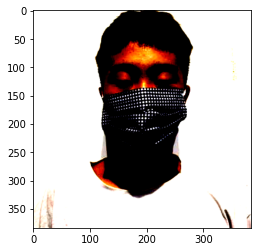

In [33]:
# Sample Image
import matplotlib.pyplot as plt
image, label = next(iter(train_dataset))

image = image.permute(1,2,0)
plt.imshow(image)

print(image.shape)

## Model

In [34]:
import timm

model = timm.create_model("vit_base_patch16_384", pretrained=True)


In [35]:
in_ftr = model.head.in_features
model.head = nn.Linear(in_ftr, 18)

In [36]:
model.train()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

In [64]:
model.to(device)

lr_rate = 1
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, mode='min', patience=2)

In [65]:
for epoch in range(epochs):
    loss_total = 0
    for index, (images, labels) in enumerate(tqdm(train_dataloader)):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        preds = model(images)
        
        loss = loss_fn(preds, labels)
        loss.backward()
        scheduler.step(1)
        loss_total += loss.item() * image.size(0)
    
    epoch_loss = loss_total / len(train_dataloader.dataset)
    print(f'epoch: {epoch}, loss: {epoch_loss}')
    

  0%|          | 0/840 [00:00<?, ?it/s]

epoch: 0, loss: 47.84774100288512


  0%|          | 0/840 [00:00<?, ?it/s]

epoch: 1, loss: 47.84774084242564


 76%|███████▌  | 636/840 [06:44<02:10,  1.57it/s]